# ガウス分布の学習

In [1]:
!date

2019年 8月23日 金曜日 21時20分21秒 JST


In [2]:
%matplotlib inline
%matplotlib nbagg

import warnings
from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from matplotlib.animation import ArtistAnimation
from IPython.display import HTML, display

warnings.filterwarnings('ignore')
plt.style.use('seaborn-darkgrid')
plt.rcParams['image.cmap'] = 'viridis'
sns.set_context('talk')

# Data

In [43]:
N = 50
mean = 2
std = 2

data = np.random.randn(N) * std + mean

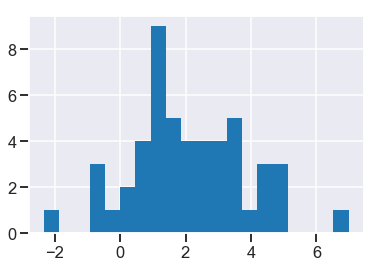

In [44]:
plt.hist(data, bins=20)
plt.show()

# 平均が未知の場合

In [40]:
class GaussMean:
    def __init__(self, mean, lmd, data_lmd, lb=-8, ub=8):
        
        self.mean = mean
        self.lmd = lmd
        self.data_lmd = data_lmd
        self.lb = lb
        self.ub = ub
        
    def sample(self, num=1):
        lmd_ast = (self.data_lmd * self.lmd 
                   * (self.data_lmd + self.lmd) ** -1)
        return np.random.randn(num) * lmd_ast ** -0.5 + self.mean
    
    def inference(self, x):
        N = len(x)
        lmd = self.lmd
        
        self.lmd = N * self.data_lmd + lmd
        self.mean = ((self.data_lmd * np.sum(x) + lmd * self.mean)
                           * self.lmd ** -1)
        
    def pdf(self, x=None):
        if x is None:
            x = np.linspace(self.lb, self.ub, 100)
            
        y = (np.exp(-(x - self.mean) ** 2 * self.lmd)
             * np.abs(self.lmd) ** 0.5 / np.sqrt(2 * np.pi))
            
        return x, y

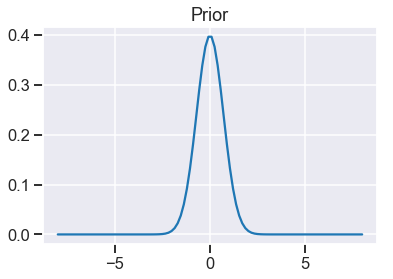

In [35]:
dist = GaussMean(0, 1, std ** -2)
plt.plot(*dist.pdf())
plt.title('Prior')
plt.show()

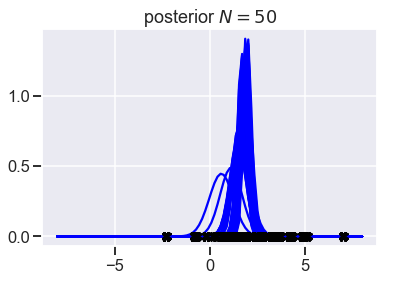

In [45]:
dist = GaussMean(0, 1, std ** -2)

frames = []
fig, ax = plt.subplots()
ax.set_title(r'posterior $N = {}$'.format(N))
for i in range(N):
    dist.inference([data[i]])
    im1 = ax.plot(*dist.pdf(), c='b')
    im2 = ax.plot(data[:i + 1], np.zeros_like(data[:i + 1]), 'X', c='k')
    frames.append(im1 + im2)

In [46]:
ani = ArtistAnimation(fig, frames)
HTML(ani.to_jshtml())

In [47]:
dist.mean

1.934475322738711

# 精度が未知の場合

In [40]:
class GaussMean:
    def __init__(self, a, b, data_mean, lb=-8, ub=8):
        
        self.mean = a
        self.lmd = b
        self.data_mean = data_mean
        self.lb = lb
        self.ub = ub
        
        self.mu_s = data_mean
        self.lmd_s = a / b
        self.nu_s = 2 * a
        
    def sample(self, num=1):
        lmd_ast = (self.data_lmd * self.lmd 
                   * (self.data_lmd + self.lmd) ** -1)
        return np.random.randn(num) * lmd_ast ** -0.5 + self.mean
    
    def inference(self, x):
        N = len(x)
        lmd = self.lmd
        
        self.lmd = N * self.data_lmd + lmd
        self.mean = ((self.data_lmd * np.sum(x) + lmd * self.mean)
                           * self.lmd ** -1)
        
    def pdf(self, x=None):
        if x is None:
            x = np.linspace(self.lb, self.ub, 100)
            
        y = (np.exp(-(x - self.mean) ** 2 * self.lmd)
             * np.abs(self.lmd) ** 0.5 / np.sqrt(2 * np.pi))
            
        return x, y

In [48]:
? np.random.standard_t

Docstring:
standard_t(df, size=None)

Draw samples from a standard Student's t distribution with `df` degrees
of freedom.

A special case of the hyperbolic distribution.  As `df` gets
large, the result resembles that of the standard normal
distribution (`standard_normal`).

Parameters
----------
df : float or array_like of floats
    Degrees of freedom, should be > 0.
size : int or tuple of ints, optional
    Output shape.  If the given shape is, e.g., ``(m, n, k)``, then
    ``m * n * k`` samples are drawn.  If size is ``None`` (default),
    a single value is returned if ``df`` is a scalar.  Otherwise,
    ``np.array(df).size`` samples are drawn.

Returns
-------
out : ndarray or scalar
    Drawn samples from the parameterized standard Student's t distribution.

Notes
-----
The probability density function for the t distribution is

.. math:: P(x, df) = \frac{\Gamma(\frac{df+1}{2})}{\sqrt{\pi df}
          \Gamma(\frac{df}{2})}\Bigl( 1+\frac{x^2}{df} \Bigr)^{-(df+1)/2}

The t test is